In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
df=pd.read_csv('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train.csv',sep=',')

In [ ]:
import os 
files=os.listdir('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train_images')
files.sort()

In [ ]:
#Ram yetmediği için resim boyutunu 400 400 den 300 300 e indiriyorum

import cv2 
img_list=[]
from tqdm import tqdm_notebook as tqdm
for i in tqdm(files):

  image=cv2.imread('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train_images//' + i)
  image=cv2.resize(image,(300,300))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  img_list.append(image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/3662 [00:00<?, ?it/s]

In [ ]:
y_train=pd.get_dummies(df['diagnosis']).values
import numpy as np
y_train_son=np.ones(y_train.shape,dtype='uint8')
y_train_son[:,4]=y_train[:,4]
for i in range(3,-1,-1):
  y_train_son[:,i]=np.logical_or(y_train[:,i],y_train_son[:,i+1])
x_train=np.array(img_list)

x_train = x_train.astype(np.float32)
x_train=x_train/255
x_train=x_train.astype(np.uint8)



from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,
                                             y_train_son,
                                             test_size=0.15,
                                             random_state=42,
                                             shuffle=True)

from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(horizontal_flip=False,vertical_flip=False)
data_generator=datagen.flow(x_train,y_train,batch_size=2,seed=2020)

In [ ]:
import keras 
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization,AveragePooling2D
from keras.optimizers import Adam 
from keras import layers

In [ ]:
model = Sequential()

#1. katman
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(300,300,3),activation='swish'))
model.add(BatchNormalization())

#2.katman

model.add(Conv2D(64, 3,activation='swish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 

#3. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())


#4. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())

#5. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Tam bağlantı katmanı
model.add(Flatten())
model.add(Dense(128,activation='swish'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Çıkış katmanı

model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.00005),metrics=['accuracy'])

from keras.callbacks import  ReduceLROnPlateau

lr=ReduceLROnPlateau(monitor='val_loss',
                     patience=3,
                     verbose=1,
                     mode='auto',
                     factor=0.25,
                     min_lr=0.000001)
                     
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 298, 298, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 296, 296, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 296, 296, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 64)     0         
 )                                                               
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit_generator(data_generator,
                            steps_per_epoch=1000,
                            epochs=15,
                            validation_data=(x_val,y_val),
                            callbacks=[lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/15
1000/1000 [==============================] - 58s 43ms/step - loss: 4.3283 - accuracy: 0.2595 - val_loss: 4.0841 - val_accuracy: 0.4382 - lr: 5.0000e-05
Epoch 2/15
1000/1000 [==============================] - 39s 39ms/step - loss: 3.8811 - accuracy: 0.4030 - val_loss: 4.3939 - val_accuracy: 0.6327 - lr: 5.0000e-05
Epoch 3/15
1000/1000 [==============================] - 40s 40ms/step - loss: 3.6988 - accuracy: 0.5220 - val_loss: 4.9183 - val_accuracy: 0.7091 - lr: 5.0000e-05
Epoch 4/15
 999/1000 [============================>.] - ETA: 0s - loss: 3.5167 - accuracy: 0.6512
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1000/1000 [==============================] - 40s 40ms/step - loss: 3.5156 - accuracy: 0.6510 - val_loss: 4.8731 - val_accuracy: 0.7618 - lr: 5.0000e-05
Epoch 5/15
1000/1000 [==============================] - 40s 40ms/step - loss: 3.4813 - accuracy: 0.7295 - val_loss: 5.3829 - val_accuracy: 0.8309 - lr: 1.2500e-05
Epoch 6/15
1000/1000 [

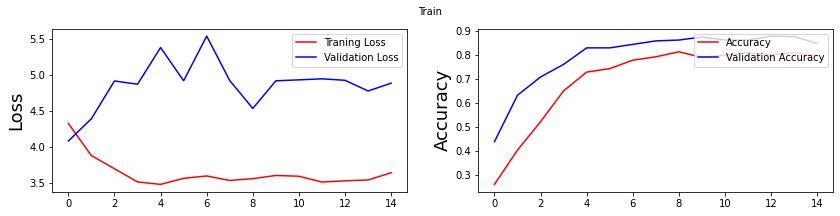

In [ ]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.suptitle('Train',fontsize=10)
plt.ylabel('Loss',fontsize=18)
plt.plot(history.history['loss'],color='r',label='Traning Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy',fontsize=18)
plt.plot(history.history['accuracy'],color='r',label='Accuracy')
plt.plot(history.history['val_accuracy'],color='b',label='Validation Accuracy')
plt.legend(loc='upper right')


plt.show()